<a href="https://colab.research.google.com/github/AryanShr/Anime-Recommendation-System/blob/main/Item_item_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
from tqdm import tqdm
import networkx as nx
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import CosineSimilarity
import tensorflow_hub as hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#####Load Json

In [ ]:
path = "/content/drive/MyDrive/Data/amazon-meta_filtered.json"

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=4107976d3ffc0ec2a68f1baa0f62bde4c670b7a73dcee2b04097152b40bea4bd
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.10/dist-packages/pyspark'

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Hackrx_Graphilic.com').getOrCreate()

In [ ]:
from pyspark.sql import functions
from pyspark.sql import types

In [ ]:
file_path = "/content/drive/MyDrive/hackrx/"

In [ ]:
categories = spark.read.option("header",True).csv(file_path+'categories.csv')

In [ ]:
categories.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------+
|ASIN      |category                                                                                                                                 |
+----------+-----------------------------------------------------------------------------------------------------------------------------------------+
|0827229534||Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]                             |
|0827229534||Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]                               |
|0738700797||Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484]                                      |
|0738700797||Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12

In [ ]:
categories = categories.withColumn("category", functions.split(functions.regexp_replace(functions.col("category"), r"\[.*?\]", ""), "\\|"))
categories.show(truncate=False)

+----------+--------------------------------------------------------------------------------------------------+
|ASIN      |category                                                                                          |
+----------+--------------------------------------------------------------------------------------------------+
|0827229534|[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Preaching]                     |
|0827229534|[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Sermons]                       |
|0738700797|[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Wicca]                        |
|0738700797|[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Witchcraft]                   |
|0486287785|[, Books, Subjects, Home & Garden, Crafts & Hobbies, General]                                     |
|0842328327|[, Books, Subjects, Religion & Spirituality, Christianity, Reference, Commentaries, New Test

In [ ]:
def flatten_category(arr):
  return list(set(x.strip() for sublist in arr for x in sublist if x.strip()))

In [ ]:
flattenUDF = functions.udf(lambda z: flatten_category(z), types.ArrayType(types.StringType()))

In [ ]:
categories = categories.groupBy('ASIN').agg(functions.collect_set("category").alias("category"))
categories = categories.withColumn('category', flattenUDF(functions.col("category")))
categories.show(truncate=False)

+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ASIN      |category                                                                                                                                                                                                             |
+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0001057170|[Humor, Entertainment, Books, Formats, General, Boxed Sets, Books on Tape, Subjects]                                                                                                                                 |
|0001474103|[Christianity, Books, Religion & Spirituality, Prophecies, Subjects, Reference] 

In [ ]:
categories.count()

87780

In [ ]:
# SHow type of category column in categories
categories.printSchema()


root
 |-- ASIN: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
second_row = categories.collect()[1]


In [ ]:
for ele in second_row['category']:
  print(ele)

Christianity
Books
Religion & Spirituality
Prophecies
Subjects
Reference


In [ ]:
for ele in categories[1]['category']:
  print(ele)

TypeError: ignored

In [ ]:
category_set = set()
for row in categories.collect():
  cat = row['category']
  for c in cat:
    category_set.add(c)

len(category_set)


17667

In [ ]:
# sort category_set
sorted_category_set = sorted(category_set)

In [ ]:
#print 10 elements of the set category_set
for i, c in enumerate(sorted_category_set):
  if i<10:
    print(c)
  else:
    break

$7 - $10
& 21st Century
& Design
& Detectives
& Legislative Bodies
& Magic
& Retail Spaces
& Telecommunications
& Word Lists
( A )


In [ ]:
for i, c in enumerate(sorted_category_set):
  if c== 'Design':
    print(True)

True


In [ ]:
proccessed_set = set()
for i, c in enumerate(sorted_category_set):
  if c.startswith('& '):
    proccessed_set.add(c[2:])
  else:
    proccessed_set.add(c)


In [ ]:
# sort category_set
sorted_category_set = sorted(proccessed_set)

In [ ]:
print(len(sorted_category_set))

17662


In [ ]:
sorted_category_set

In [ ]:
similar = spark.read.option("header",True).csv(file_path+'similar.csv')

In [ ]:
similar.show(truncate=False)

+----------+----------+
|ASIN      |ASIN ID   |
+----------+----------+
|0827229534|0804215715|
|0827229534|156101074X|
|0827229534|0687023955|
|0827229534|0687074231|
|0827229534|082721619X|
|0738700797|0738700827|
|0738700797|1567184960|
|0738700797|1567182836|
|0738700797|0738700525|
|0738700797|0738700940|
|0842328327|0842328130|
|0842328327|0830818138|
|0842328327|0842330313|
|0842328327|0842328610|
|0842328327|0842328572|
|1577943082|157794349X|
|1577943082|0892749504|
|1577943082|1577941829|
|1577943082|0892749563|
|1577943082|1577946006|
+----------+----------+
only showing top 20 rows



In [56]:
similar = similar.groupBy('ASIN').agg(functions.collect_set("ASIN ID").alias("similar set"))
similar.show(truncate=False)

+----------+------------------------------------------------------------+
|ASIN      |similar set                                                 |
+----------+------------------------------------------------------------+
|0001057170|[B00006JMQR, 1585673080]                                    |
|0001474103|[0001472933, 0895403889, 0766187403, 0766177610, 0001473123]|
|0002250985|[0912365307, 0060188243, 0394555295, 0446528269, 1558530649]|
|0002251965|[0002154129, 000215949X, 0002250357, 0002553481, 0002159317]|
|0004722817|[0004708474, 0007127596, 0004708490, 0004708466]            |
|0004724534|[0007137222, 0007127596, 0007137214, 0873418247, 0760315604]|
|0006386709|[0060516402, 1591396190, 1857883195, 0385267320, 0316172324]|
|0006482848|[1400030102, 1400030056, 1400030137, 0375719334, 0375719350]|
|0006482864|[1400030072, 1400030080, 1400030110, 1400030129, 0375719350]|
|0006491790|[1556431430, 1560449179, 0151005796, 0865475091, 1883319900]|
|0006531806|[1891620541, 1574888498, 0

In [60]:
similar_item = similar.rdd.map(lambda row: (row['ASIN'], row['similar set'])).collectAsMap()


In [61]:
# Print first ten elements from similar_item
import itertools
for key, value in itertools.islice(similar_item.items(), 10):
    print(f"{key}: {value}")

0001057170: ['B00006JMQR', '1585673080']
0001474103: ['0001472933', '0895403889', '0766187403', '0766177610', '0001473123']
0002250985: ['0912365307', '0060188243', '0394555295', '0446528269', '1558530649']
0002251965: ['0002154129', '000215949X', '0002250357', '0002553481', '0002159317']
0004722817: ['0004708474', '0007127596', '0004708490', '0004708466']
0004724534: ['0007137222', '0007127596', '0007137214', '0873418247', '0760315604']
0006386709: ['0060516402', '1591396190', '1857883195', '0385267320', '0316172324']
0006482848: ['1400030102', '1400030056', '1400030137', '0375719334', '0375719350']
0006482864: ['1400030072', '1400030080', '1400030110', '1400030129', '0375719350']
0006491790: ['1556431430', '1560449179', '0151005796', '0865475091', '1883319900']


In [84]:
import networkx as nx

In [108]:
graph = nx.Graph()

In [100]:
nodes = set()
for key, value in itertools.islice(similar_item.items(), 10):
    nodes.add(key)
    for val in value:
      nodes.add(val)

nodes = list(nodes)

In [102]:
len(nodes)

54

In [112]:
graph.add_nodes_from(similar_item.keys())
# graph.add_nodes_from(nodes)

In [113]:
# graph.add_edges_from([(key, item) for key, value in itertools.islice(similar_item.items(),10) for item in value])
graph.add_edges_from([(key, item) for key, value in similar_item.items() for item in value])

In [70]:
for i in similar_item['0001057170']:
  print(i)

B00006JMQR
1585673080


In [77]:
g = nx.Graph()
g.add_node("0001057170")
for i in similar_item['0001057170']:
  g.add_edge("0001057170",str(i))

Exception ignored in: <function _xla_gc_callback at 0x7d4a0f71ac20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

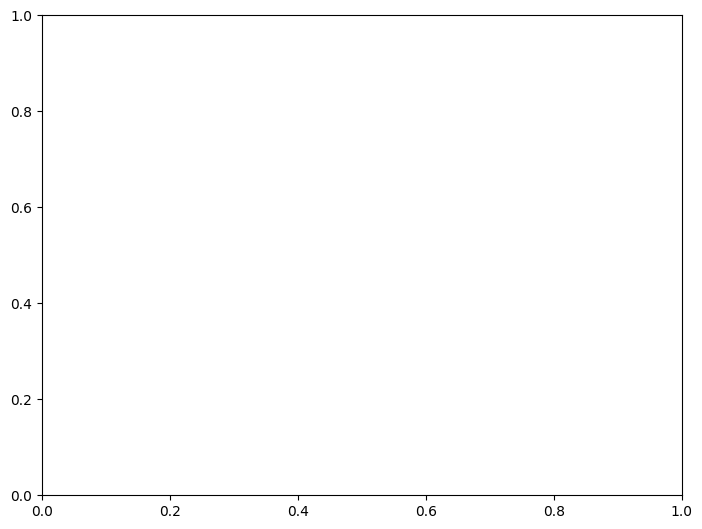

In [114]:
nx.draw(graph,with_labels=False,node_size = 100)